In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_repump_Christian.jl")
working_dir = "C:\\Google Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"
;

In [3]:
function survived(t_end, times, trajectories)
    _survived = Int64[]
    for i ∈ eachindex(trajectories)
        if times[i][end] ≈ t_end*1e3
            push!(_survived, i)
        end
    end
    return _survived
end

function cloud_size(trajectories, i)
    std(trajectory[i] for trajectory ∈ trajectories)
end

"""
    Evaluates the density given a set of trajectories.
"""
function density(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    println(_survived)
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = length(_survived)
    _density = Float64(n)
    if n > 1
        idx_end = length(surviving_x_trajectories[1])
        σ_x = cloud_size(surviving_x_trajectories, idx_end)
        σ_y = cloud_size(surviving_y_trajectories, idx_end)
        σ_z = cloud_size(surviving_z_trajectories, idx_end)
        _density /= σ_x * σ_y * σ_z
    end
    return _density
end

function distance(x_trajectory, y_trajectory, z_trajectory, idx)
    return sqrt(x_trajectory[idx]^2 + y_trajectory[idx]^2 + z_trajectory[idx]^2)
end

goodness_val(r) = r <= 0.8 ? (0.8 - r)^3 : 0
"""
    Evaluates how many particles are within a 0.3 mm radius.
"""
function goodness(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    @printf("Survival: %i / %i", length(_survived), n_molecules)
    println()
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(x_trajectories[survived_idx])
        r = distance(x_trajectories[survived_idx], y_trajectories[survived_idx], z_trajectories[survived_idx], idx_end)
        n += goodness_val(r) * exp(-results.photons_scattered[survived_idx] / 15000)
    end
    return n/n_molecules
end

using LsqFit

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2)) 
end

function cloud_size(i, trajectories)
    
    xs = [trajectory[i] for trajectory ∈ trajectories]

    hist_data = fit(Histogram, xs, nbins=5)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    v_fit = curve_fit(Gaussian, v, fv, [0.5, 0., 10])
    σ, x0, A = v_fit.param

    return σ
end
;

### Set up the molecule

In [4]:
package = get_CaOH_package()
n_states = length(package.states)
n_excited = package.n_excited
;

##### Scan a single configuration

In [5]:
s1 = 1.00*3
s2 = 0*0.50
s3 = 1.50*3
s4 = 2.00*3
Δ1 = +2.18Γ
Δ2 = -2.00Γ
Δ3 = Δ1
Δ4 = -6.41Γ
ramp_time = 10e-3
B_gradient = -20

temp = @with_unit 0.050 "mK"
diameter = @with_unit 2.0 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]

params = MutableNamedTuple(t_end = 20e-3, n_values = 20,
                           pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                           s1=s1, s2=s2, s3=s3, s4=s4,
                           Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                           B_gradient = B_gradient, 

                           temp=temp, diameter=diameter, 
                           displacement=displacement, kick=kick,
                           ramp_time = ramp_time,
                           photon_budget=Inf, dark_lifetime=1/(0.05e6), FC_mainline=0.95,

                           pol_imbalance=0.05, 
                           s_imbalance = (0*1.0, 0*1.0, 0*1.0), retro_loss=0.1, 

                           off_center=[0,4,0,0,0,0].*1e-3, 
                           pointing_error =[0., 0., 0, 0, 0, 0]
)

results = simulate_particles_repump(package, params)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


In [6]:
_survived = survived(params.t_end, results.times, results.x_trajectories)
surviving_x_trajectories = results.x_trajectories[_survived]
surviving_y_trajectories = results.y_trajectories[_survived]
surviving_z_trajectories = results.z_trajectories[_survived]
length(_survived) |> display
;

19

In [7]:
idx_end = length(surviving_x_trajectories[1])
cloud_size(idx_end, surviving_x_trajectories) |> display
cloud_size(idx_end, surviving_y_trajectories) |> display
cloud_size(idx_end, surviving_z_trajectories) |> display

0.33122106995960976

0.2374192647994024

0.10847372465961812

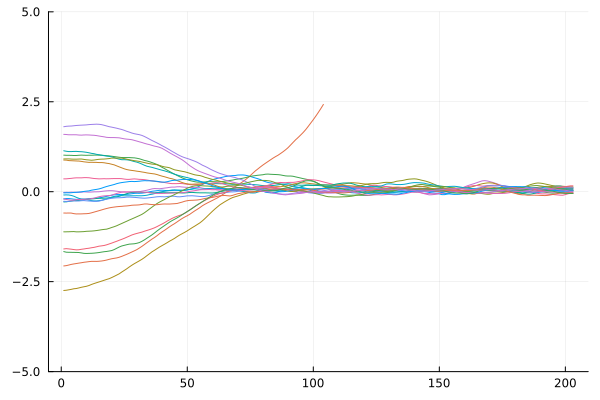

In [8]:
plot(results.z_trajectories, legend=nothing, ylim=(-5,5))

In [9]:
mean(results.photons_scattered / 20e-3)

559035.0

In [5]:
"""
    Function to optimize (density).
"""
function f(x)
    s1 = x[1]
    s3 = x[2]
    s4 = x[3]
    Δ1 = x[4]*Γ
    Δ3 = Δ1
    Δ4 = x[5]*Γ
    ramp_time = 10e-3
    B_gradient = -25

    temp = @with_unit 0.050 "mK"
    diameter = @with_unit 2.0 "mm"
    displacement = [0.0, 0.0, 0.0]
    kick = [0,0, 0.0, 0.0]
    
    pol1_x = x[6] > 0 ? σ⁻ : σ⁺
    pol3_x = x[7] > 0 ? σ⁻ : σ⁺
    pol4_x = x[8] > 0 ? σ⁻ : σ⁺
        
    params = MutableNamedTuple(t_end = 30e-3, n_values = 20,
                           pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                           s1=s1, s2=0., s3=s3, s4=s4,
                           Δ1=Δ1, Δ2=0., Δ3=Δ3, Δ4=Δ4, 
                           B_gradient = B_gradient,

                           temp=temp, diameter=diameter, 
                           displacement=displacement, kick=kick,
                           ramp_time = ramp_time,
                           photon_budget=15000, dark_lifetime=1/(0.04e6), FC_mainline=0.95,

                           pol_imbalance=0.05, 
                           s_imbalance = (0*1.0, 0*1.0, 0*1.0), retro_loss=0.1, 

                           off_center=[4,0,0,0,0,0].*1e-3, 
                           pointing_error =[0., 0., 0, 0, 0, 0]
    )
    
    results = simulate_particles_repump(package, params)
    
    @printf("s1 = %.2f; s3 = %.2f; s4 = %.2f; Δ1 = %.2f Γ; Δ3 = Δ1; Δ4 = %.2f Γ; pol1 = %.2f; pol3 = %.2f; pol4 = %.2f", x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8])
    println()
    
    _goodness = goodness(params.t_end, results) * 1e3
    @printf("goodness = %.3f", _goodness)
    println()
    
    return _goodness
end
;    

In [7]:
using BayesianOptimization, GaussianProcesses

model = ElasticGPE(8,                            # 6 input dimensions
                   mean = MeanConst(1.),         
                   kernel = SEArd([1., 1, 1, 1, 1, 1, 1, 1], 5.),
                   logNoise = 0.,
                   capacity = 3000)              # the initial capacity of the GP is 3000 samples
set_priors!(model.mean, [Normal(0., 0.01)])

# Optimize the hyperparameters of the GP using maximum a posteriori (MAP) estimates every x steps
modeloptimizer = MAPGPOptimizer(
    every = 1, 
    noisebounds = [-3, 3], # bounds of the logNoise
    kernbounds = [[-3, -3, -3, -3, -3, -3, -3, -3, -5], [3, 3, 3, 3, 3, 3, 3, 3, 5]],  # bounds of the parameters GaussianProcesses.get_param_names(model.kernel)
    maxeval = 1000
)

opt = BOpt(f,
           model,
           UpperConfidenceBound(),             # type of acquisition
           modeloptimizer,                        
           [0.5, 0.5, 0.5, +0.5, -8.0, -1, -1, -1],        # lowerbounds
           [4.0, 4.0, 10., +4.0, -0.5, 1, 1, 1],        # upperbounds         
           repetitions = 1,                          # evaluate the function for each input x times
           maxiterations = 50,                       # evaluate at x input positions
           sense = Max,                              # maximize the function
           acquisitionoptions = (method = :LD_LBFGS, # run optimization of acquisition function with NLopts :LD_LBFGS method
                                 restarts = 10,       # run the NLopt method from x random initial conditions each time
                                 maxtime = 1.0,      # run the NLopt method for at most 1.0 second each time
                                 maxeval = 5000),    # run the NLopt methods for at most 1000 iterations (for other options see https://github.com/JuliaOpt/NLopt.jl)
           verbosity = BayesianOptimization.Progress)

# result = boptimize!(opt);
;

┌ Warning: use values(kwargs) and keys(kwargs) instead of kwargs.data and kwargs.itr
│   caller = #MAPGPOptimizer#19 at gp.jl:37 [inlined]
└ @ Core C:\Users\Christian\.julia\packages\BayesianOptimization\nq1HY\src\models\gp.jl:37


In [10]:
using BayesianOptimization, GaussianProcesses
using Serialization
opt_old = deserialize(joinpath(working_dir, "optimized_3freqs_with_imperfections_withpolarizations.jl"));
opt.model = opt_old.model;
opt.model_optimum = opt_old.model_optimum;
opt.model_optimizer = opt_old.model_optimizer;
opt.modeloptimizer = opt_old.modeloptimizer;
opt.observed_optimum = opt_old.observed_optimum;
opt.observed_optimizer = opt_old.observed_optimizer;
# opt.acquisition = opt_old.acquisition;
# opt.acquisitionoptions = opt_old.acquisitionoptions;

In [ ]:
# using Serialization
    
# while true
#     maxiterations!(opt, 50)
#     result = boptimize!(opt)
#     serialize("optimized_3freqs_with_imperfections_withpolarizations.jl", opt)
#     println("===== Autosaved =====")
# end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22Progress:  10%|█████                                    |  ETA: 0:00:30
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


s1 = 0.66; s3 = 1.43; s4 = 7.18; Δ1 = 2.41 Γ; Δ3 = Δ1; Δ4 = -6.95 Γ; pol1 = 0.84; pol3 = 0.59; pol4 = 0.34
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


s1 = 2.41; s3 = 3.18; s4 = 2.43; Δ1 = 0.66 Γ; Δ3 = Δ1; Δ4 = -3.20 Γ; pol1 = -0.16; pol3 = -0.41; pol4 = -0.66
Survival: 4 / 20
goodness = 7.275


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


s1 = 3.29; s3 = 0.55; s4 = 9.55; Δ1 = 3.29 Γ; Δ3 = Δ1; Δ4 = -1.32 Γ; pol1 = -0.66; pol3 = 0.09; pol4 = -0.16
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


s1 = 1.54; s3 = 2.30; s4 = 4.80; Δ1 = 1.54 Γ; Δ3 = Δ1; Δ4 = -5.07 Γ; pol1 = 0.34; pol3 = -0.91; pol4 = 0.84
Survival: 4 / 20
goodness = 15.916


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 1.98; s3 = 0.99; s4 = 1.24; Δ1 = 1.98 Γ; Δ3 = Δ1; Δ4 = -6.01 Γ; pol1 = 0.59; pol3 = 0.34; pol4 = -0.41
Survival: 5 / 20
goodness = 5.121


Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


s1 = 3.73; s3 = 2.74; s4 = 5.99; Δ1 = 3.73 Γ; Δ3 = Δ1; Δ4 = -2.26 Γ; pol1 = -0.41; pol3 = -0.66; pol4 = 0.59
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


s1 = 2.85; s3 = 1.87; s4 = 3.62; Δ1 = 1.10 Γ; Δ3 = Δ1; Δ4 = -4.13 Γ; pol1 = -0.91; pol3 = 0.84; pol4 = 0.09
Survival: 3 / 20
goodness = 10.086


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 1.10; s3 = 3.62; s4 = 8.37; Δ1 = 2.85 Γ; Δ3 = Δ1; Δ4 = -7.88 Γ; pol1 = 0.09; pol3 = -0.16; pol4 = -0.91
Survival: 4 / 20
goodness = 0.307


Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


s1 = 1.32; s3 = 0.77; s4 = 3.02; Δ1 = 3.95 Γ; Δ3 = Δ1; Δ4 = -2.73 Γ; pol1 = 0.47; pol3 = 0.47; pol4 = -0.28
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


s1 = 3.07; s3 = 2.52; s4 = 7.77; Δ1 = 2.20 Γ; Δ3 = Δ1; Δ4 = -6.48 Γ; pol1 = -0.53; pol3 = -0.53; pol4 = 0.72
Survival: 6 / 20
goodness = 18.917


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 3.95; s3 = 1.65; s4 = 0.65; Δ1 = 3.07 Γ; Δ3 = Δ1; Δ4 = -4.60 Γ; pol1 = -0.03; pol3 = 0.97; pol4 = 0.22
Survival: 10 / 20
goodness = 24.108


Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


s1 = 2.20; s3 = 3.40; s4 = 5.40; Δ1 = 1.32 Γ; Δ3 = Δ1; Δ4 = -0.85 Γ; pol1 = 0.97; pol3 = -0.03; pol4 = -0.78
Survival: 4 / 20
goodness = 2.717


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


s1 = 1.76; s3 = 2.09; s4 = 8.96; Δ1 = 0.88 Γ; Δ3 = Δ1; Δ4 = -1.79 Γ; pol1 = 0.22; pol3 = 0.72; pol4 = 0.47
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


s1 = 3.51; s3 = 3.84; s4 = 4.21; Δ1 = 2.63 Γ; Δ3 = Δ1; Δ4 = -5.54 Γ; pol1 = -0.78; pol3 = -0.28; pol4 = -0.53
Survival: 3 / 20
goodness = 1.568


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 2.63; s3 = 1.21; s4 = 6.59; Δ1 = 1.76 Γ; Δ3 = Δ1; Δ4 = -7.41 Γ; pol1 = -0.28; pol3 = 0.22; pol4 = -0.03
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


s1 = 0.88; s3 = 2.96; s4 = 1.84; Δ1 = 3.51 Γ; Δ3 = Δ1; Δ4 = -3.66 Γ; pol1 = 0.72; pol3 = -0.78; pol4 = 0.97
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


s1 = 0.77; s3 = 1.32; s4 = 8.07; Δ1 = 0.99 Γ; Δ3 = Δ1; Δ4 = -4.84 Γ; pol1 = -0.84; pol3 = -0.47; pol4 = -0.09
Survival: 1 / 20
goodness = 0.173


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


s1 = 2.52; s3 = 3.07; s4 = 3.32; Δ1 = 2.74 Γ; Δ3 = Δ1; Δ4 = -1.09 Γ; pol1 = 0.16; pol3 = 0.53; pol4 = 0.91
Survival: 1 / 20
goodness = 0.245


Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


s1 = 3.40; s3 = 2.20; s4 = 5.70; Δ1 = 1.87 Γ; Δ3 = Δ1; Δ4 = -2.96 Γ; pol1 = 0.66; pol3 = -0.97; pol4 = 0.41
Survival: 3 / 20
goodness = 9.441


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


s1 = 1.65; s3 = 3.95; s4 = 0.95; Δ1 = 3.62 Γ; Δ3 = Δ1; Δ4 = -6.71 Γ; pol1 = -0.34; pol3 = 0.03; pol4 = -0.59
Survival: 2 / 20
goodness = 0.275


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


s1 = 2.09; s3 = 1.76; s4 = 4.51; Δ1 = 3.18 Γ; Δ3 = Δ1; Δ4 = -7.65 Γ; pol1 = -0.59; pol3 = -0.72; pol4 = 0.16
Survival: 2 / 20
goodness = 5.499


s1 = 3.84; s3 = 3.51; s4 = 9.26; Δ1 = 1.43 Γ; Δ3 = Δ1; Δ4 = -3.90 Γ; pol1 = 0.41; pol3 = 0.28; pol4 = -0.84
Survival: 5 / 20
goodness = 9.618


Progress: 100%|█████████████████████████████████████████| Time: 0:00:33
Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


s1 = 2.96; s3 = 0.88; s4 = 2.13; Δ1 = 2.30 Γ; Δ3 = Δ1; Δ4 = -2.02 Γ; pol1 = 0.91; pol3 = -0.22; pol4 = -0.34
Survival: 2 / 20
goodness = 2.053


Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


s1 = 1.21; s3 = 2.63; s4 = 6.88; Δ1 = 0.55 Γ; Δ3 = Δ1; Δ4 = -5.77 Γ; pol1 = -0.09; pol3 = 0.78; pol4 = 0.66
Survival: 4 / 20
goodness = 6.008


Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


s1 = 0.99; s3 = 1.98; s4 = 2.73; Δ1 = 1.65 Γ; Δ3 = Δ1; Δ4 = -0.62 Γ; pol1 = -0.47; pol3 = -0.59; pol4 = 0.03
Survival: 1 / 20
goodness = 0.004


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


s1 = 2.74; s3 = 3.73; s4 = 7.48; Δ1 = 3.40 Γ; Δ3 = Δ1; Δ4 = -4.37 Γ; pol1 = 0.53; pol3 = 0.41; pol4 = -0.97
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


In [ ]:
plot(moving_average(opt.model.y, 100))

In [24]:
opt.observed_optimum

49.85152909844105

In [23]:
opt.observed_optimizer

8-element Vector{Float64}:
  3.2224455936289824
  1.842321004850293
  3.8625522588126797
  3.349191378729903
 -5.910334399538269
  1.0
 -1.0
  1.0

In [21]:
opt.model_optimum

22.36129590482566

In [22]:
opt.model_optimizer

8-element Vector{Float64}:
  3.0797177893299805
  2.350473715104055
  5.038287683424049
  3.119650315240279
 -7.371411458167795
  0.3821674489530465
  1.0
  1.0

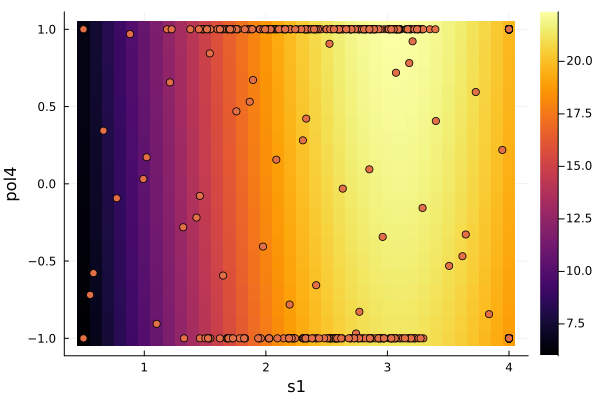

In [20]:
# variables = ["s1", "s2", "s3", "s4", "Δ1=Δ3", "Δ2", "Δ4"]
variables = ["s1", "s3", "s4", "Δ1=Δ3", "Δ4", "pol1", "pol3", "pol4"]

idx1 = 1
idx2 = 8

list1 = opt.lowerbounds[idx1]:0.1:opt.upperbounds[idx1]
list2 = opt.lowerbounds[idx2]:0.1:opt.upperbounds[idx2]

preds_mat = zeros(length(list1), length(list2))
points = zeros(8, 1)

for (i, val1) ∈ enumerate(list1)
    for (j, val2) ∈ enumerate(list2)
        points[:,1] .= opt.model_optimizer
        points[idx1,1] = val1
        points[idx2,1] = val2
        preds_mat[i,j] = predict_y(opt.model, points)[1][1]
    end
end
heatmap(list1, list2, preds_mat')
scatter!(opt.model.x[idx1,:], opt.model.x[idx2,:], legend=nothing, xlabel=variables[idx1], ylabel=variables[idx2])

In [112]:
opt.acquisition

UpperConfidenceBound{BrochuBetaScaling}(BrochuBetaScaling(0.1), 9.530831449357468)

In [30]:
opt.model_optimizer

7-element Vector{Float64}:
  4.0
  3.2953050501635595
  0.1860363733133069
  4.0
  4.0
 -5.0
 27.801602313493724

In [31]:
opt.observed_optimizer

7-element Vector{Float64}:
  4.0
  4.0
  0.0
  4.0
  0.5
 -1.0
 50.0

In [31]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

moving_average (generic function with 1 method)

In [42]:
opt.func = f

f (generic function with 1 method)

In [43]:
methods(f)

# 1 method for generic function "f" from Main:
 [1] f(x)
     @ In[38]:16

## Running a single configuration

In [58]:
temp = @with_unit 0.1 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]

params = MutableNamedTuple(t_end = 1e-3, n_values = 20,
                            pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, 
                            s1=2.0, s2=0.0, s3=0.05, s4=0.05,
                            Δ1=4.0Γ, Δ2=-0.8Γ, Δ3=-1.0Γ, Δ4=+0.5Γ, 
                            B_gradient = 30, 
                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            ramp_time = 4e-3)
;

results = simulate_particles_v2(package, params);

In [60]:
density(params.t_end, results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories)

36.24340520601817

## Scanning configurations

In [55]:
# fixed:
t_end = 30e-3 #s
n_values = 20
ramp_time = 4e-3 #s
B_gradient = 30 #G/cm

temp = @with_unit 0.5 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]

# variable:
pol1_x_list = [σ⁻]
pol2_x_list = [σ⁺]
pol3_x_list = [σ⁻]
pol4_x_list = [σ⁺]

s1_list = [1.5, 2.0, 2.5]
s2_list = [0.0]
s3_list = [0.05, 0.1]
s4_list = [0.05, 0.1]

Δ1_list = [2.0, 4.0, 6.0] .* Γ
Δ2_list = [0.0]
Δ3_list = [-0.5, -1.0, -1.5] .* Γ
Δ4_list = [0.5, 1.0, 1.5] .* Γ

lists = [pol1_x_list, pol2_x_list, pol3_x_list, pol4_x_list,
        s1_list, s2_list, s3_list, s4_list,
        Δ1_list, Δ2_list, Δ3_list, Δ4_list]

n_scans = 1
for l in lists
   n_scans *= length(l) 
end

comments = "scan d3 +- 1MHz";
saving_dir = make_scan_folder(lists, working_dir, 1, comments);

scan_counter = 0
indicies = [
    1,1,1,1, 
    1,1,1,1, 
    1,1,1,1
];

In [ ]:
while scan_counter < n_scans
    @printf("============= configuration %i / %i =============", scan_counter+1, n_scans)
    println()
    
    pol1_x = pol1_x_list[indicies[1]]
    pol2_x = pol2_x_list[indicies[2]]
    pol3_x = pol3_x_list[indicies[3]]
    pol4_x = pol4_x_list[indicies[4]]
    s1 = s1_list[indicies[5]]
    s2 = s2_list[indicies[6]]
    s3 = s3_list[indicies[7]]
    s4 = s4_list[indicies[8]]
    Δ1 = Δ1_list[indicies[9]]
    Δ2 = Δ2_list[indicies[10]]
    Δ3 = Δ3_list[indicies[11]]
    Δ4 = Δ4_list[indicies[12]]
    
    params = MutableNamedTuple(t_end = t_end, n_values = n_values,
                            pol1_x=pol1_x, pol2_x=pol2_x, pol3_x=pol3_x, pol4_x=pol4_x, 
                            s1=s1, s2=s2, s3=s3, s4=s4,
                            Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                            B_gradient = B_gradient, 
                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            ramp_time = ramp_time)

    test_i = log_test_info(saving_dir,1,params)
    
    results = simulate_particles(package, params, params.n_values);

    save_results(saving_dir, test_i, results)
    
    scan_counter += 1 
    next_configuration!(lists, indicies)
    
end
;

============= configuration 1 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


============= configuration 2 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


============= configuration 3 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 4 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


============= configuration 5 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


============= configuration 6 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


============= configuration 7 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


============= configuration 8 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


============= configuration 9 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 10 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


============= configuration 11 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


============= configuration 12 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


============= configuration 13 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


============= configuration 14 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 15 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 16 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


============= configuration 17 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 18 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 19 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 20 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


============= configuration 21 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 22 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


============= configuration 23 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


============= configuration 24 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


============= configuration 25 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


============= configuration 26 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:49


============= configuration 27 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:48


============= configuration 28 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


============= configuration 29 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


============= configuration 30 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


============= configuration 31 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:53


============= configuration 32 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:46


============= configuration 33 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


============= configuration 34 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:38


============= configuration 35 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 36 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 37 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


============= configuration 38 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 39 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 40 / 324 =============


Progress:  70%|█████████████████████████████            |  ETA: 0:00:37┌ Error: Error watching manifest
│   exception =
│    LoadError: UndefVarError: `@reexport` not defined
│    in expression starting at C:\Users\Christian\.julia\packages\StatsFuns\atA5S\src\StatsFuns.jl:8
└ @ Revise C:\Users\Christian\.julia\packages\Revise\Kw99o\src\pkgs.jl:477
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


============= configuration 41 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:03


============= configuration 42 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:50


============= configuration 43 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:30


============= configuration 44 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:40


============= configuration 45 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:48


============= configuration 46 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:08


============= configuration 47 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


============= configuration 48 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:51


============= configuration 49 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 50 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:51


============= configuration 51 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


============= configuration 52 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:43


============= configuration 53 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


============= configuration 54 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 55 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


============= configuration 56 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 57 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 58 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


============= configuration 59 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:45


============= configuration 60 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 61 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:48


============= configuration 62 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


============= configuration 63 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 64 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:49


============= configuration 65 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 66 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:00


============= configuration 67 / 324 =============


Progress:  25%|███████████                              |  ETA: 0:04:54┌ Error: Error watching manifest
│   exception =
│    LoadError: UndefVarError: `@reexport` not defined
│    in expression starting at C:\Users\Christian\.julia\packages\StatsFuns\atA5S\src\StatsFuns.jl:8
└ @ Revise C:\Users\Christian\.julia\packages\Revise\Kw99o\src\pkgs.jl:477
Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 68 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


============= configuration 69 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


============= configuration 70 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:53


============= configuration 71 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:53
